In [1]:
# Data Flattening
import numpy as np
import pandas as pd

import datetime
from datetime import datetime

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, MapType, LongType
from pyspark.sql.functions import lit, udf, size, avg, min as min_, max as max_, sum as sum_, count, countDistinct, col, mean, stddev, struct, explode, explode_outer, unix_timestamp, sum as sum_
from operator import itemgetter
import json

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import Bucketizer

from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, collect_set, row_number, dense_rank, lead, lag, rank
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegressionModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import collections
from collections import deque
import redis
import json

import matplotlib as mpl
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:

env = "production"
# env = "staging"
DATE = '2020-01-2*/'
file_path = 's3://mist-secorapp-{env}/oc-stats-analytics/oc-stats-analytics-{env}/dt={date}/*'.format(env=env, date=DATE)
df = spark.read.parquet(file_path)
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- org_id: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- when: long (nullable = true)
 |-- remote_addr: string (nullable = true)
 |-- clients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- vlan_name: string (nullable = true)
 |    |    |-- mac: string (nullable = true)
 |    |    |-- flags: string (nullable = true)
 |    |    |-- age: integer (nullable = true)
 |    |    |-- iface_name: string (nullable = true)
 |    |    |-- vlan_id: integer (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- hostname: string (nullable = true)
 |    |    |-- dhcpbound: integer (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- auth_state: string (nullable = true)
 |    |    |-- auth_method: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- mo

In [3]:
# site_id = "6f643507-d233-4fb1-98bd-e4445446270e"
# switch_mac = "d0dd496c8bbd" # .replace(":", "")

df1 = df
switch_id = "1c:9c:8c:ba:29:70".replace(":", "")
if env == "staging":
    site_id = "f688779c-e335-4f88-8d7c-9c5e9964528b"  # wired assurance
#     switch_id = "1c:9c:8c:ba:29x:70".replace(":", "")
    switch_id = "1c:9c:8c:ba:2d:44".replace(":", "")
#     df1 = df.filter(col("site_id").isin([site_id]))
    df1 = df.filter(col("id").isin([switch_mac]))



In [4]:
df1 =df.filter(col("site_id")=="13a5b2f6-4bcc-40e4-b385-7c866cdde0fb")


In [5]:
df1.count()

11587

In [6]:
# df1.columns# to pandas 
import pandas as pd
df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
df1_i.take(1)


[Row(id='5800bb997801', when=1580247508175537, org_id='5cc036bb-1f32-4f3e-998c-3434e04e78fd', site_id='13a5b2f6-4bcc-40e4-b385-7c866cdde0fb', name='ge-0/0/0', link=True, full_duplex=True, mbps=100, mtu=1514, address='', admin_status=True, last_flapped=1578676037000000, errors=[], poe_enabled=True, poe_status=True, poe_power_limit=10.0, poe_power=3.4000000953674316, poe_priority=False, poe_class='3', poe_mode='', rx_bytes=747114, rx_bps=90168, rx_packets=3633, tx_bytes=989563, tx_bps=108344, tx_packets=5080, rx_errors=0, rx_undersize_errors=0, rx_oversize_errors=0, rx_fcserrors=0, rx_overrun_errors=0, rx_discards=0, tx_errors=0, tx_drops=0, tx_mtuerrors=0, txcarrier_transition=0, tx_mcast_packets=520, tx_bcast_packets=909, rx_mcast_packets=4, rx_bcast_packets=909, interface_counter_delta=True, rx_l3_incompletes=0, rx_l2_channel_error=0, rx_l2_mismatch_timeouts=0, rx_fifo_errors=0, rx_resource_errors=0, auto_negotiation_status='complete', media_type='copper', remote_chassis_id='', remote

In [7]:
# df1_1 = df1_i.filter(col("site_id")=="13a5b2f6-4bcc-40e4-b385-7c866cdde0fb")
df_pd = df1_i.toPandas()
df_pd.head()

Py4JJavaError: An error occurred while calling o49.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 189 in stage 5.0 failed 1 times, most recent failure: Lost task 189.0 in stage 5.0 (TID 801, localhost, executor driver): ExecutorLostFailure (executor driver exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 10363662 ms
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
df_pd.head()

In [43]:
# to pandas 
import pandas as pd
# df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("interfaces")).alias("interface")).select('id','when', 'org_id', 'site_id', 'interface.*')
# df1_i.take(1)

df1_i = df1.select(col("id"), col("when"), col("org_id"), col("site_id"), explode(col("clients")).alias("client")).select('id','when', 'org_id', 'site_id', 'client.*')

df_pd = df1_i.toPandas()

df1_i.filter(col("dhcpbound")>0)

DataFrame[id: string, when: bigint, org_id: string, site_id: string, vlan_name: string, mac: string, flags: string, age: int, iface_name: string, vlan_id: int, ip: string, hostname: string, dhcpbound: int, username: string, group: string, auth_state: string, auth_method: string]

In [44]:
df_pd.head()

,id,when,org_id,site_id,vlan_name,mac,flags,age,iface_name,vlan_id,ip,hostname,dhcpbound,username,group,auth_state,auth_method
0,1c9c8cba2d44,1580503350149961,b4e16c72-d50e-4c03-a952-a3217e231e2c,f688779c-e335-4f88-8d7c-9c5e9964528b,v86,5c5b350eb7c2,,0,ge-0/0/9,86,0.0.0.0,5c5b350eb7c2,0,,,,
1,1c9c8cba2d44,1580503350149961,b4e16c72-d50e-4c03-a952-a3217e231e2c,f688779c-e335-4f88-8d7c-9c5e9964528b,v87,accc8ee1add4,,0,ge-0/0/2,87,10.86.86.38,axis-accc8ee1add4,0,,,,
2,1c9c8cba2d44,1580503350149961,b4e16c72-d50e-4c03-a952-a3217e231e2c,f688779c-e335-4f88-8d7c-9c5e9964528b,v88,5c5b350e57b2,,0,ge-1/0/6,88,10.88.88.9,Mist,1,,,,
3,1c9c8cba2d44,1580503350149961,b4e16c72-d50e-4c03-a952-a3217e231e2c,f688779c-e335-4f88-8d7c-9c5e9964528b,,1c9c8cba2e7f,,0,ge-0/0/4,0,10.2.13.64,SW3,0,,,,
4,1c9c8cba2d44,1580503350149961,b4e16c72-d50e-4c03-a952-a3217e231e2c,f688779c-e335-4f88-8d7c-9c5e9964528b,,d0dd4985b348,,0,,0,10.2.14.108,ex2300-2_apfw_svr_room,0,,,,


In [45]:
df_pd.columns

Index(['id', 'when', 'org_id', 'site_id', 'vlan_name', 'mac', 'flags', 'age',
       'iface_name', 'vlan_id', 'ip', 'hostname', 'dhcpbound', 'username',
       'group', 'auth_state', 'auth_method'],
      dtype='object')

In [46]:
df_pd_with_dhcp = df_pd[df_pd['dhcpbound']>0]

# df_pd[['id', 'mac', 'iface_name', 'dhcpbound']].groupby([ 'id', 'mac', 'iface_name', 'dhcpbound']).count()

df_pd[['id', 'mac', 'iface_name', 'dhcpbound']].groupby([ 'id', 'mac', 'iface_name', 'dhcpbound']).count()

Empty DataFrame
Columns: []
Index: [(1c9c8cba2d44, 1c9c8cba2e7f, ge-0/0/4, 0), (1c9c8cba2d44, 1c9c8cba2e7f, ge-1/0/5, 0), (1c9c8cba2d44, 2047470c2f39, ge-0/0/10, 0), (1c9c8cba2d44, 2047470c2f39, ge-0/0/10, 2), (1c9c8cba2d44, 2047470c2f39, ge-1/0/6, 0), (1c9c8cba2d44, 2047470c2f39, ge-1/0/6, 2), (1c9c8cba2d44, 503237936272, ge-1/0/6, 0), (1c9c8cba2d44, 503237936272, ge-1/0/6, 1), (1c9c8cba2d44, 503237936272, ge-1/0/6, 2), (1c9c8cba2d44, 5c5b350e465f, ge-0/0/10, 0), (1c9c8cba2d44, 5c5b350e57b2, ge-1/0/6, 0), (1c9c8cba2d44, 5c5b350e57b2, ge-1/0/6, 1), (1c9c8cba2d44, 5c5b350e57b2, ge-1/0/6, 2), (1c9c8cba2d44, 5c5b350eb7c2, ge-0/0/9, 0), (1c9c8cba2d44, accc8ee1add4, ge-0/0/2, 0), (1c9c8cba2d44, d0dd4985b348, , 0), (1c9c8cba2d44, fc334262c500, , 0)]

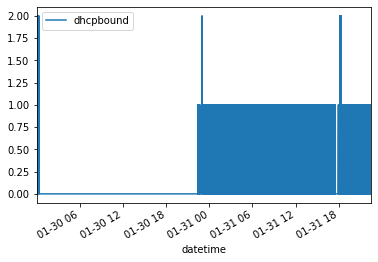

In [49]:


df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]
df_pd[df_pd["id"]==switch_id].plot(x="datetime", y="dhcpbound")


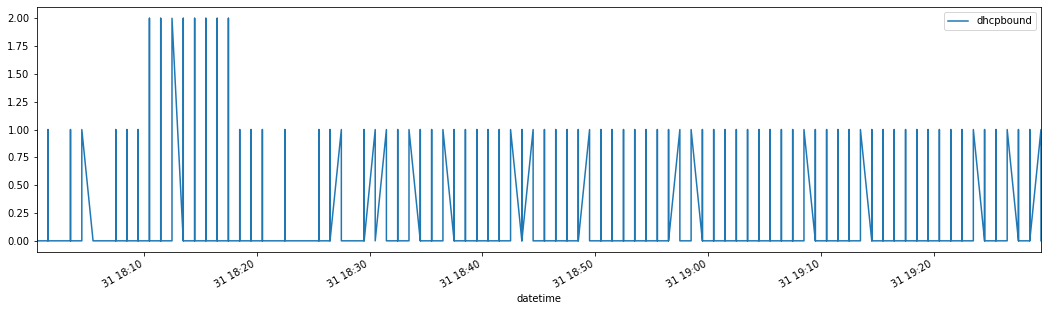

In [52]:
t0 = '2020-01-31 18:0:00'
t1 = '2020-01-31 19:30:00'
df_sel = df_pd[df_pd["id"]==switch_id][(df_pd['datetime']>t0)&(df_pd['datetime']<t1)]
df_sel.plot(x="datetime", y="dhcpbound", figsize=(18, 5))

In [ ]:
set(df_pd[df_pd["id"]==switch_id]['dhcpbound']), switch_mac

In [42]:
df_pd['datetime']


0        2020-01-31 20:42:22.344662
1        2020-01-31 20:42:22.344662
2        2020-01-31 20:42:35.745236
3        2020-01-31 20:42:35.745236
4        2020-01-31 20:42:35.745236
                    ...            
158274   2020-01-30 02:59:47.678016
158275   2020-01-30 02:59:47.678016
158276   2020-01-30 02:59:47.678016
158277   2020-01-30 02:59:43.268676
158278   2020-01-30 02:59:43.268676
Name: datetime, Length: 158279, dtype: datetime64[ns]

In [22]:
df_sel = df_pd[df_pd["mac"]==switch_mac][(df_pd['datetime']>'2020-01-29 00:0:00')&(df_pd['datetime']<'2020-01-29 01:30:00')]
df_sel.plot(x="datetime", y="dhcpbound", figsize=(18, 5))

/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


TypeError: no numeric data to plot

In [27]:
# df_pd[df_pd['id']=="d0:dd:49:6c:8b:bd".replace(":", "")]

,id,when,org_id,site_id,vlan_name,mac,flags,age,iface_name,vlan_id,ip,hostname,dhcpbound,username,group,auth_state,auth_method
0,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b35504a2e,,0,ge-0/0/1,100,192.168.100.153,DK1-AP1,0,,,,
1,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000bab9e2c04,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
2,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,000c299f4f4c,,0,ge-0/0/4,100,0.0.0.0,,0,,,,
3,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,84248d189390,,0,ge-0/0/5,100,192.168.100.159,dk1-wired-1,0,,,,
4,d0dd496c8bbd,1580242843878155,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b354eb6c6,,0,ge-0/0/7,100,192.168.100.142,DK1-AP2,0,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22779,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,84248d189390,,0,ge-0/0/5,100,192.168.100.159,dk1-wired-1,0,,,,
22780,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,5c5b354eb6c6,,0,ge-0/0/7,100,192.168.100.142,DK1-AP2,0,,,,
22781,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,v100,705ab6b4c7b0,,0,ge-0/0/8,100,0.0.0.0,,0,,,,
22782,d0dd496c8bbd,1580093973397275,774dcf84-ed15-4406-b769-09f556911a19,6f643507-d233-4fb1-98bd-e4445446270e,,d007ca696340,,0,ge-0/0/0,0,69.196.157.187,DK1SRX1,0,,,,
